# 04_Feed-forward_Neural_Networks
In this notebook, we will see how to define simple feed-foward neural networks.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(777)  # reproducibility

## Neural Networks
A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using an optimizer.

We will look at all the above processes with a concrete example, MNIST.

### Define the network
First of all, we need a new feed-foward neural network for performing image classification on MNIST.
In PyTorch, you can build your own neural network using the `torch.nn`package:

In [2]:
# Hyper-parameters
input_size = 784
hidden_size = 256
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        # Define the operations to use for input processing.
        # torch.nn.Linear(in_features, out_features, bias=True)
        #               : a linear projection(fc) layer(in_feeatures -> out_features)
        # torch.nn.RELU(inplace=False): a ReLU activation function
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        # Define the input processing through network
        z1 = self.fc1(x)
        h1 = self.relu(z1)
        out = self.fc2(h1)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)
print(model)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


You just have to define the `forward` function, and the `backward` function (where gradients are computed) is automatically defined for you using `autograd`.

The architecture of the above `NeuralNet` is as follows:
<img src="images/nn_architecture.png" width="500">

Here, x and y are the input, target (true label) values, respectively.

The learnable parameters of a model are returned by `model.parameters()`.

In [3]:
params = list(model.parameters())
print(len(params))
print(params[0].size())  # fc1's .weight

4
torch.Size([256, 784])


### Loss function and Optimizer
A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target.

There are several different loss functions under the nn package.
We use `nn.CrossEntropyLoss()`.

In [4]:
input = torch.randn(1, 784) # a random input, for example
output = model(input) # output: (batch_size, num_classes)
print(output)

target = torch.tensor([0])  # a dummy target, for example. target: (batch_size) where 0 <= each element < num_classes
criterion = nn.CrossEntropyLoss()

loss = criterion(output, target)
print(loss)

tensor([[-0.0980, -0.5035,  0.0184,  0.0011,  0.0577,  0.2312,  0.1687,  0.0417,
         -0.1924, -0.0033]], grad_fn=<ThAddmmBackward>)
tensor(2.3904, grad_fn=<NllLossBackward>)


Furtheremore, PyTorch supports several optimizers from `torch.optim`.
We use an Adam optimizer.

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### DataLoader

torch.Size([60000, 28, 28])
torch.Size([60000])


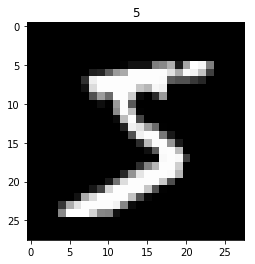

In [6]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# plot one example
print(train_dataset.train_data.size())                 # (60000, 28, 28)
print(train_dataset.train_labels.size())               # (60000)

idx = 0
plt.title('%d' % train_dataset.train_labels[idx].item())
plt.imshow(train_dataset.train_data[idx,:,:].numpy(), cmap='gray')

### Train the network

In [7]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # backward + optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, running_loss / 100))
            running_loss = 0.0

Epoch [1/5], Step [100/600], Loss: 0.7585
Epoch [1/5], Step [200/600], Loss: 0.3331
Epoch [1/5], Step [300/600], Loss: 0.2676
Epoch [1/5], Step [400/600], Loss: 0.2476
Epoch [1/5], Step [500/600], Loss: 0.2130
Epoch [1/5], Step [600/600], Loss: 0.2064
Epoch [2/5], Step [100/600], Loss: 0.1720
Epoch [2/5], Step [200/600], Loss: 0.1571
Epoch [2/5], Step [300/600], Loss: 0.1458
Epoch [2/5], Step [400/600], Loss: 0.1467
Epoch [2/5], Step [500/600], Loss: 0.1403
Epoch [2/5], Step [600/600], Loss: 0.1157
Epoch [3/5], Step [100/600], Loss: 0.1057
Epoch [3/5], Step [200/600], Loss: 0.1060
Epoch [3/5], Step [300/600], Loss: 0.1023
Epoch [3/5], Step [400/600], Loss: 0.0955
Epoch [3/5], Step [500/600], Loss: 0.0909
Epoch [3/5], Step [600/600], Loss: 0.0918
Epoch [4/5], Step [100/600], Loss: 0.0748
Epoch [4/5], Step [200/600], Loss: 0.0810
Epoch [4/5], Step [300/600], Loss: 0.0664
Epoch [4/5], Step [400/600], Loss: 0.0731
Epoch [4/5], Step [500/600], Loss: 0.0700
Epoch [4/5], Step [600/600], Loss:

### Test the network

In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

### Save/Load the network parameters

In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), './data/nn_model.ckpt')

# Load the model checkpoint if needed
# new_model = NeuralNet(input_size, hidden_size, num_classes).to(device)
# new_model.load_state_dict(torch.load('./data/nn_model.ckpt'))

## Practice: CIFAR10

<img src="images/cifar10.png" width="400">

The CIFAR-10 dataset has the following specification:
- The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.
- CIFAR-10 has the ten classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.

You have to define a feed-foward neural network with two hidden layers for performing image classifcation on the CIFAR-10 dataset as well as train and test the network.

In [ ]:
# Hyper-parameters
input_size = 3*32*32
hidden1_size = 512
hidden2_size = 128
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# Device configuration
device = torch.device('cpu')

# transform images to tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Write the code to define a neural network with two hidden layers.
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        # ============ YOUR CODE HERE ============
        
        # ========================================
    
    def forward(self, x):
        # ============ YOUR CODE HERE ============
        return x # DUMMY
        # ========================================

model = Net(input_size, hidden1_size, hidden2_size, num_classes).to(device)
print(model)

# Write the code to train and test the network.
# ============ YOUR CODE HERE ============
        
# ========================================